In [357]:
import pandas as pd
import re
import numpy as np
import time
import csv


# spark_context = SparkSession.builder.master("local").appName("main").getOrCreate()

fire_dep = pd.read_csv('Seattle_Real_Time_Fire_911_Calls.csv')
contractors = pd.read_csv('L_I_Contractor_License_Data_-_General.csv')
abbr = pd.read_csv('street_abbr.csv')
# wa_voters = pd.read_csv('WashingtonStateVoterExtract/20221101_VRDB_Extract.txt', sep = '|')

In [358]:
vars_to_use = [('FName', 1), ('MName', 2), ('LName', 3), ('Registrationdate', 31), ('Mail1', 23), ('Mail2', 24), ('Mail3', 25), ('StatusCode', 34)]
# Registration Date and the combintion of RegStNum, RegStName, and RegStFrac are important for the join. 

voters = []

voters_path = 'WashingtonStateVoterExtract/20221101_VRDB_Extract.txt'
with open(voters_path) as file:
    wa_voters = csv.reader(file, delimiter="|")
    for row in wa_voters:
        voter = {}
        for var_index in vars_to_use:
            voter.update({var_index[0]: row[var_index[1]]})
        voters.append(voter)
        

In [359]:
voters_df = pd.DataFrame(voters[1:len(voters)], columns = voters[0])
voters_df = voters_df[voters_df['Mail1'] != '']
voters_df = voters_df[~voters_df['Mail1'].isna()]
voters_df = voters_df[voters_df['StatusCode'] == 'Active']

In [360]:
# This cell enables quick development by removing limiting the size of the data

# voters_df = voters_df[0:50000]
# fire_dep = fire_dep[0:50000]
# contractors = contractors[0:50000]

In [361]:
abbr['full'] = abbr['full'].str.lower()
abbr['abbr'] = abbr['abbr'].str.lower()
abbr.head()

,full,abbr
0,alley,aly
1,avenue,ave
2,boulevard,blvd
3,causeway,cswy
4,center,ctr


In [362]:
# Need to data clean with the steps below:
# lower
# remove punctuation

def apply_regex(address):
    '''Uses regular expressions to format the address data fora join.'''
    
    address = str(address)
    
    new_str = address.lower()
    end_str = re.sub(r'[^\w\s]', '', new_str)
    
    for i in range(len(abbr)):
        end_str = end_str.replace(abbr['full'][i], abbr['abbr'][i])
    
    return end_str

print(apply_regex(contractors['Address1'][0]))

print("""Expected Runtime is ~9min. \nOver 1 mil records and expensive str search operation.\n
    Could parallelize with Spark but that's too much work""")

start = time.perf_counter()

contractors['join_address'] = contractors['Address1'].apply(apply_regex)
fire_dep['join_address'] = fire_dep['Address'].apply(apply_regex)
print("Time: ", start - time.perf_counter())


11506 meridian ave n
Expected Runtime is ~9min. 
Over 1 mil records and expensive str search operation.

    Could parallelize with Spark but that's too much work
Time:  -518.7798617000008


In [363]:
# Should take about 10 minutes to run
#  ('RegStPreDirection', 12), ('RegStUnitNum', 14)

voters_df['join_address'] = voters_df['Mail1'].apply(apply_regex)


In [364]:
# Need to get only the most recent contractor for each address in the contractors dataset. 
contractors['recency'] = contractors.sort_values(['LicenseEffectiveDate'])\
    .groupby(['join_address'])\
    .cumcount() + 1

# a recency of 1 is the newest record. 

contractors[contractors['join_address'] == '0607 sw idaho st'][['LicenseEffectiveDate', 'recency']]

contractors = contractors[contractors['recency'] == 1]

In [365]:
# Need to think about other data cleaning steps to improve the re-identification. 

In [366]:
# Manages the join. 

joined_data = pd.merge(fire_dep, contractors, on = "join_address", how = 'left')
joined_data.sort_values(['recency'])
print('hiding head of data from Github for privacy')

hiding head of data from Github for privacy


In [367]:
# Calculates what percentage of fire department emergencies are linked to contractors. 

total_incidents = len(joined_data)
joined_incidents = len(joined_data[np.isnan(joined_data['recency']) == False])


In [368]:
print('Percent of the dataset identified: ', 100 * joined_incidents / total_incidents)

Percent of the dataset identified:  1.225101952372791


In [369]:
# need to think about joining on dates so that you only get incidents 
# that are after the contractor moved into the unit. 

In [370]:
joined_incidents

21230

In [371]:
joined_data_full = pd.merge(joined_data, voters_df, on = "join_address", how = 'left')

In [372]:
joined_data_full.to_csv('joined_data_full.csv', index = False)

In [373]:
if 'joined_data_full' not in locals() and 'joined_data_full' not in globals():
    joined_data_full = pd.read_csv('joined_data_full.csv')

In [374]:
voters_joined = len(joined_data_full[joined_data_full['FName'].isna() == False])

# This line ensures that the entire notebook does not need to be re-run. 
if 'joined_incidents' not in locals() and 'joined_incidents' not in globals():
    joined_incidents = 21230

data = pd.DataFrame.from_records([{'Dataset':'Fire Dept', 'Size':len(joined_data_full)/ len(joined_data_full)},
                                  {'Dataset':'Voter Matches', 'Size':voters_joined/ len(joined_data_full)},
                                 {'Dataset':'Contractor Matches', 'Size':joined_incidents/ len(joined_data_full)},
                                 ])

In [384]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

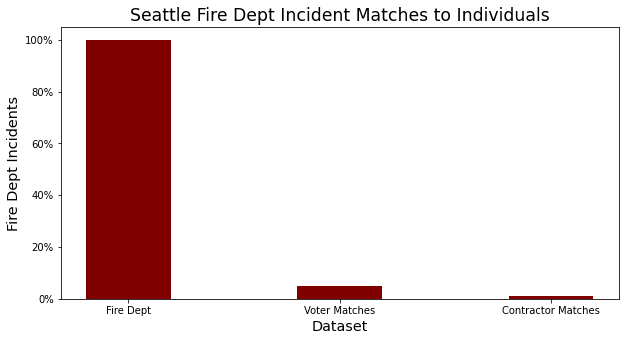

<Figure size 432x288 with 0 Axes>

In [385]:
fig, ax = plt.subplots(figsize = (10,5))

ax.bar(data['Dataset'], data['Size'],  color ='maroon', width = 0.4)

ax.set_xlabel("Dataset", fontsize = 'x-large')
ax.set_ylabel("Fire Dept Incidents", fontsize = 'x-large')
ax.set_title("Seattle Fire Dept Incident Matches to Individuals", fontsize = 'xx-large')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.show()
plt.savefig('plot.svg', format='svg')


## Open questions
1. What percent of Seattle voters live in a multi-unit home? What percent of fire department calls have a unit number?
 -- Can you answer the impact by just removing the unit number?
 -- What about Mail 2-4? 

ANSWER: the addresses in the voters dataset are entered free form and don't really make a lot of sense. Lots of preprocessing would be required to add them correctly. 

In [387]:
voters_joined

85209